In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

In [2]:
class DummyAttention:
    def __init__(self):
        self.data = np.random.normal(size=(50,50))

        self.weight_key = np.random.normal(size=(50,50))
        self.weight_query = np.random.normal(size=(50,50))
        self.weight_value = np.random.normal(size=(50,50))

    def key(self):
        return self.weight_key @ self.data

    def query(self):
        return self.weight_query @ self.data

    def value(self):
        return self.weight_value @ self.data

    def forward(self):
        k = self.key()
        q = self.query()
        v = self.value()

        scores = k @ q.T
        # scores = scores / k.shape[0]**0.5
        scores = np.exp(scores) / np.sum(scores)


        attn = scores @ v
        return attn


In [3]:
a = DummyAttention()
att = a.forward()
print(att.shape)
att

(50, 50)


<ipython-input-2-4ae27dbb9f11>:25: RuntimeWarning: overflow encountered in exp
  scores = np.exp(scores) / np.sum(scores)
<ipython-input-2-4ae27dbb9f11>:28: RuntimeWarning: invalid value encountered in matmul
  attn = scores @ v


array([[            -inf,              nan,             -inf, ...,
                     nan,              nan,             -inf],
       [             nan,              nan,              nan, ...,
                     nan,              nan,              nan],
       [             inf,             -inf,             -inf, ...,
                    -inf,             -inf,             -inf],
       ...,
       [             nan,              nan,             -inf, ...,
                     nan,              nan,              nan],
       [             nan,              nan,              nan, ...,
                     nan,              nan,              nan],
       [ 8.76690776e+287, -1.46209868e+288,  3.75935280e+287, ...,
        -2.05046520e+288,  2.42168854e+288,  8.21407438e+286]])

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Perform linear projections
        Q = self.query(q)  # (batch_size, seq_length, d_model)
        K = self.key(k)    # (batch_size, seq_length, d_model)
        V = self.value(v)  # (batch_size, seq_length, d_model)

        # Split the projections into multiple heads and reshape
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_length, d_k)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_length, d_k)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_length, d_k)

        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)  # (batch_size, num_heads, seq_length, seq_length)

        if mask is not None:
            mask = torch.broadcast_to(mask.unsqueeze(1), (batch_size, self.num_heads, mask.shape[-1],mask.shape[-1]))
            scores = scores.masked_fill(mask == 0, -1e20)

        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, num_heads, seq_length, seq_length)

        # Apply attention weights to the values
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, num_heads, seq_length, d_k)

        # Concatenate the heads and reshape
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)  # (batch_size, seq_length, d_model)

        # Final linear layer
        output = self.out(attention_output)  # (batch_size, seq_length, d_model)

        return output

In [5]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [7]:
class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, vocab_size, max_seq_len, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = self._generate_positional_encoding(max_seq_len, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def _generate_positional_encoding(self, max_seq_len, d_model):
        pos = torch.arange(max_seq_len).unsqueeze(1)
        i = torch.arange(d_model).unsqueeze(0)
        angle_rates = 1 / torch.pow(10000, (2 * (i // 2)) / torch.tensor(d_model, dtype=torch.float32))
        pos_encoding = pos * angle_rates
        pos_encoding[:, 0::2] = torch.sin(pos_encoding[:, 0::2])
        pos_encoding[:, 1::2] = torch.cos(pos_encoding[:, 1::2])
        return pos_encoding.unsqueeze(0)

    def forward(self, x, mask=None):
        seq_len = x.size(1)
        x = self.embedding(x)
        x = x + self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, tgt_mask=None, memory_mask=None):
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))

        enc_dec_attn_output = self.enc_dec_attn(x, enc_output, enc_output, memory_mask)
        x = self.norm2(x + self.dropout(enc_dec_attn_output))

        ff_output = self.ff(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, vocab_size, max_seq_len, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = self._generate_positional_encoding(max_seq_len, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def _generate_positional_encoding(self, max_seq_len, d_model):
        pos = torch.arange(max_seq_len).unsqueeze(1)
        i = torch.arange(d_model).unsqueeze(0)
        angle_rates = 1 / torch.pow(10000, (2 * (i // 2)) / torch.tensor(d_model, dtype=torch.float32))
        pos_encoding = pos * angle_rates
        pos_encoding[:, 0::2] = torch.sin(pos_encoding[:, 0::2])
        pos_encoding[:, 1::2] = torch.cos(pos_encoding[:, 1::2])
        return pos_encoding.unsqueeze(0)

    def forward(self, x, enc_output, tgt_mask=None, memory_mask=None):
        seq_len = x.size(1)
        x = self.embedding(x)
        x = x + self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, enc_output, tgt_mask, memory_mask)
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, src_vocab_size, max_seq_len, dropout)
        self.decoder = Decoder(d_model, num_heads, d_ff, num_layers, tgt_vocab_size, max_seq_len, dropout)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, tgt_mask, memory_mask)
        output = self.fc_out(dec_output)
        return output

In [ ]:
def create_src_mask(src, pad_idx):
    src_mask = (src != pad_idx).unsqueeze(-2)
    return src_mask

def create_tgt_mask(tgt, pad_idx):
    tgt_pad_mask = (tgt != pad_idx).unsqueeze(-2)
    tgt_len = tgt.size(1)
    tgt_sub_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
    tgt_mask = tgt_pad_mask & tgt_sub_mask
    return tgt_mask

In [ ]:
src_vocab_size = 10000
tgt_vocab_size = 10000
d_model = 512
num_heads = 8
d_ff = 2048
num_layers = 6
max_seq_len = 100
dropout = 0.1
pad_idx = 0

# updated

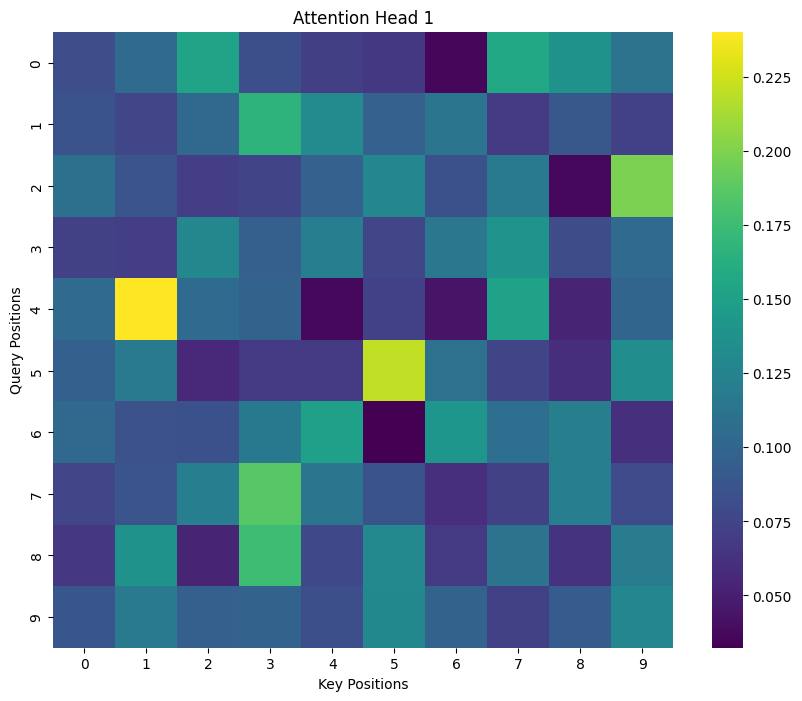

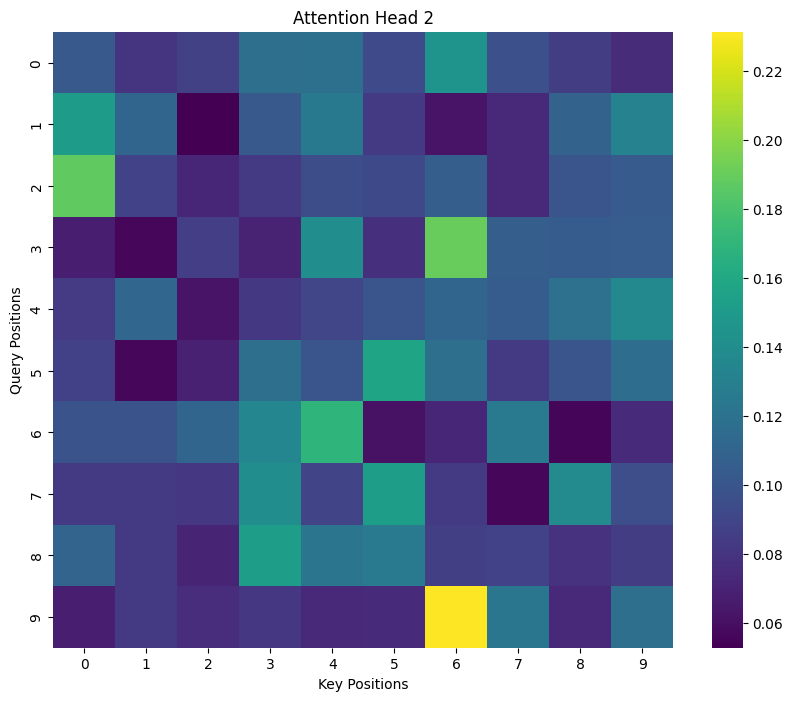

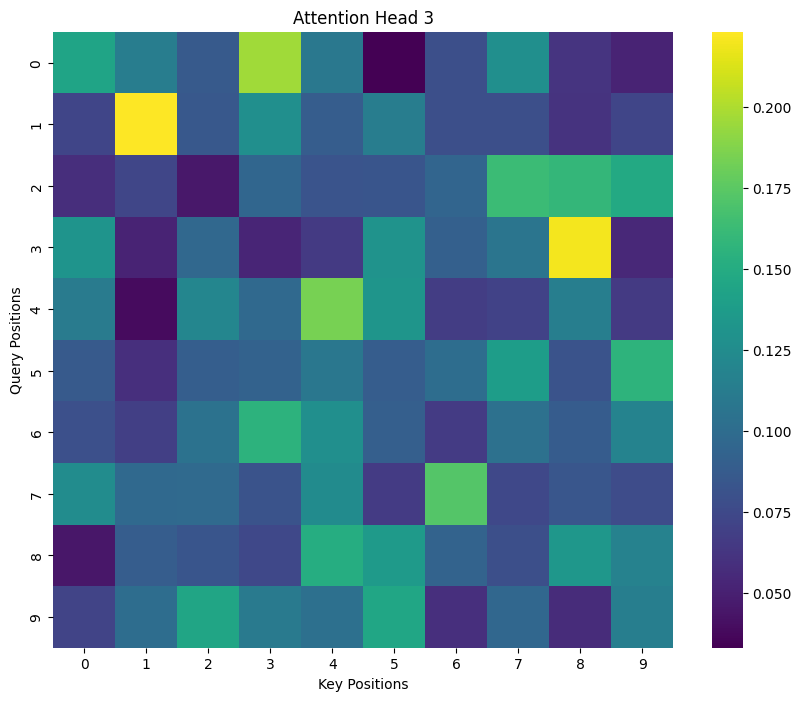

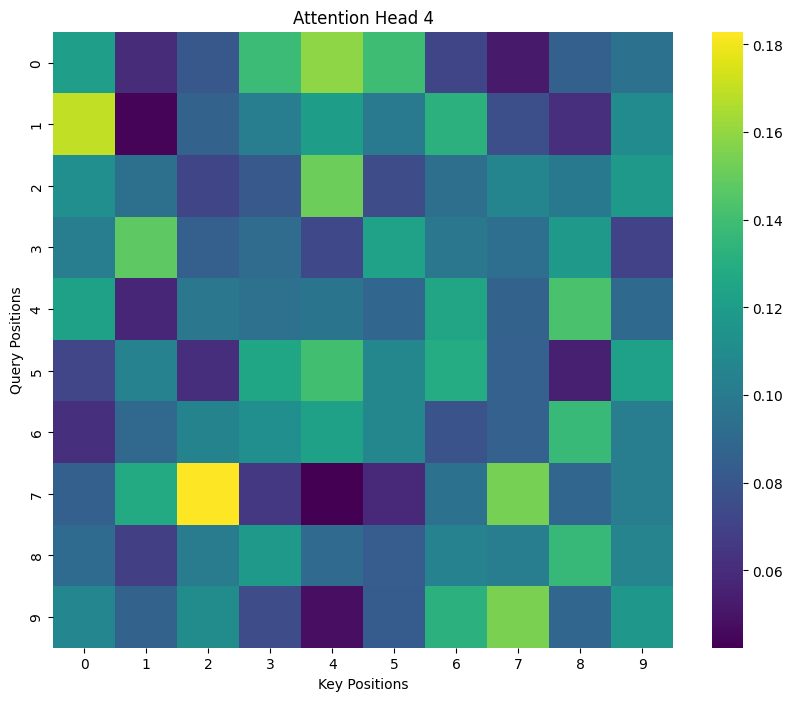

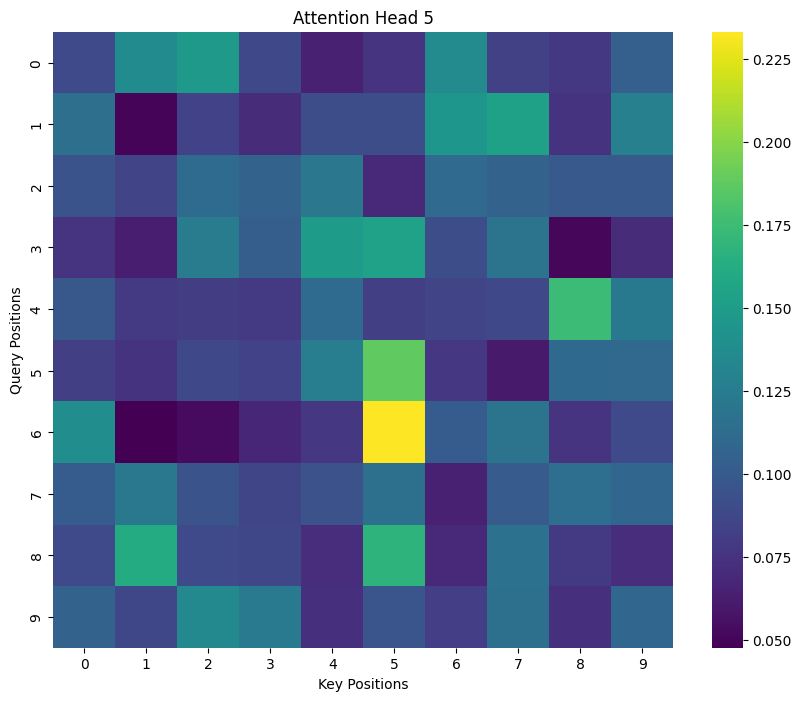

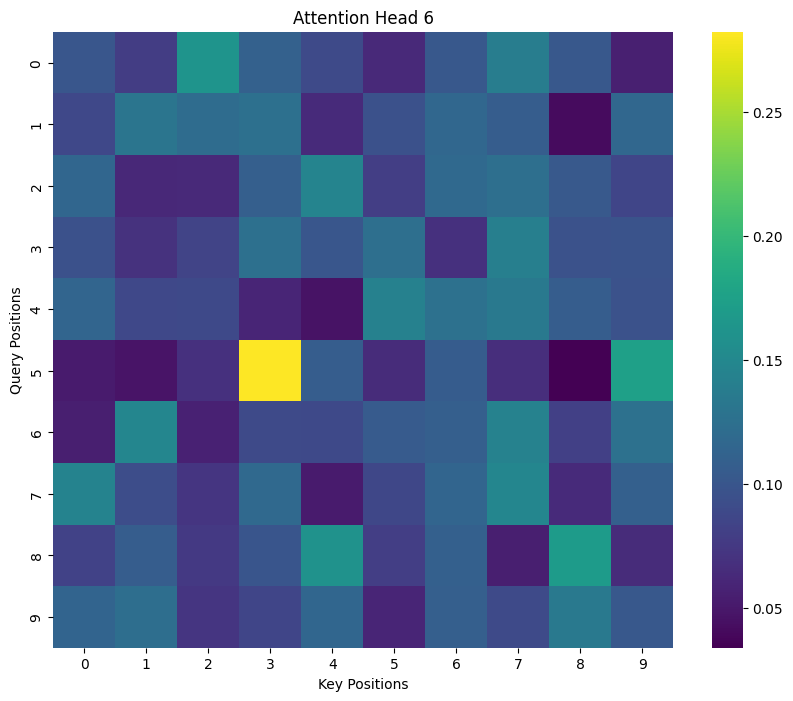

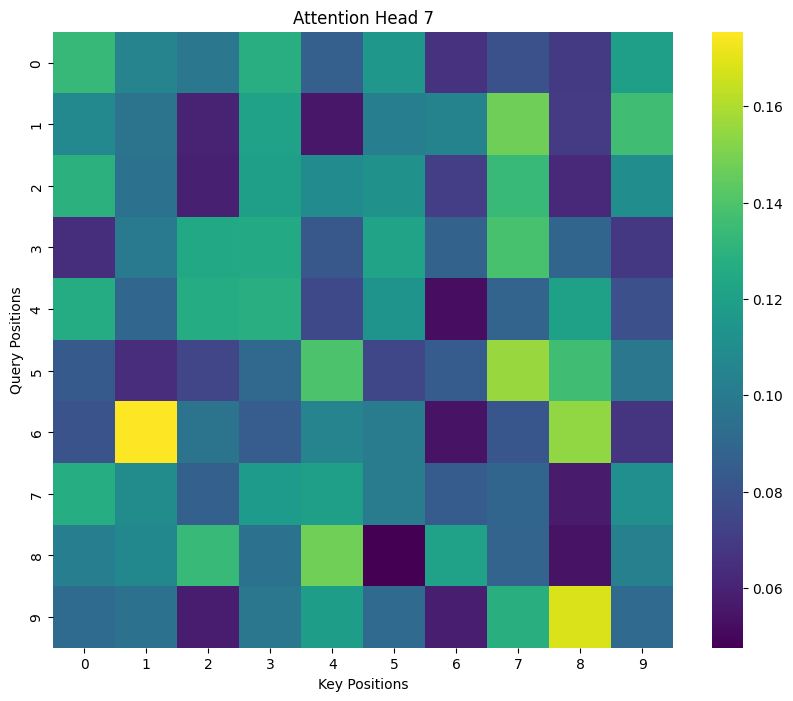

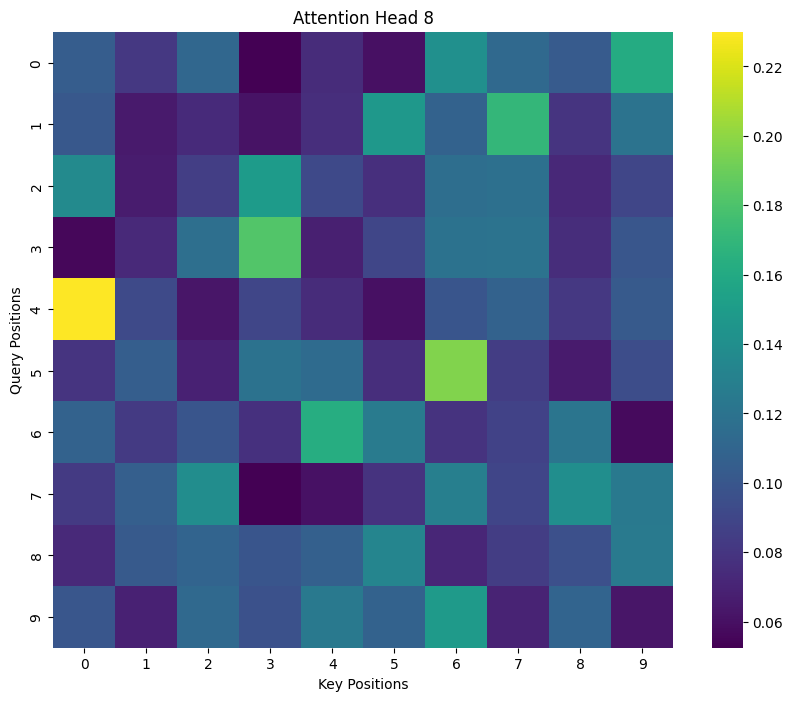

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Perform linear projections
        Q = self.query(q)  # (batch_size, seq_length, d_model)
        K = self.key(k)    # (batch_size, seq_length, d_model)
        V = self.value(v)  # (batch_size, seq_length, d_model)

        # Split the projections into multiple heads and reshape
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_length, d_k)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_length, d_k)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_length, d_k)

        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)  # (batch_size, num_heads, seq_length, seq_length)

        if mask is not None:
            mask = torch.broadcast_to(mask.unsqueeze(1), (batch_size, self.num_heads, mask.shape[-1], mask.shape[-1]))
            scores = scores.masked_fill(mask == 0, -1e20)

        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, num_heads, seq_length, seq_length)

        # Apply attention weights to the values
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, num_heads, seq_length, d_k)

        # Concatenate the heads and reshape
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)  # (batch_size, seq_length, d_model)

        # Final linear layer
        output = self.out(attention_output)  # (batch_size, seq_length, d_model)

        return output, attention_weights

def plot_attention_weights(attention_weights):
    num_heads = attention_weights.size(1)
    for head in range(num_heads):
        plt.figure(figsize=(10, 8))
        sns.heatmap(attention_weights[0, head].cpu().detach().numpy(), cmap="viridis")
        plt.title(f'Attention Head {head + 1}')
        plt.xlabel('Key Positions')
        plt.ylabel('Query Positions')
        plt.show()


# Initialize the MultiHeadAttention layer
multi_head_attn = MultiHeadAttention(d_model=512, num_heads=8)

# Dummy input tensors
q = torch.randn(1, 10, 512)
k = torch.randn(1, 10, 512)
v = torch.randn(1, 10, 512)

# Forward pass
output, attn_weights = multi_head_attn(q, k, v)

# Plot attention weights
plot_attention_weights(attn_weights)
